Домашнее задание по теме «Ансамблирование»
Преподаватель: Алексей Кузьмин
Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
Построить случайный лес, вывести важность признаков
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [1481]:
# Include external libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from prettytable import PrettyTable

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [1482]:
# Load of dataset, printing of shape of dataset
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
print("train shape ===================================================")
print(data_train.shape)
print("test shape ===================================================")
print(data_test.shape)

train shape ===================================================
(1460, 81)
test shape ===================================================
(1459, 80)


In [1483]:
# Observing of train data  structure
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [1484]:
# Observing of train data
print(data_train.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [1485]:
print(data_test.info())
# Observing of test data
print(data_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [1486]:
# Observing of sample submission data
print(sample_submission.head())
# Observing of sample submission structure
print(sample_submission.info())

     Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
None


In [1487]:
# Load significant columns (previously manually selected)
columns = pd.read_csv('./columns.csv')
# Convertion to suitable type
columns['Columns'] = columns['Columns'].astype('str')
# Observing of columns structure
print(columns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 1 columns):
Columns    35 non-null object
dtypes: object(1)
memory usage: 360.0+ bytes
None


In [1488]:
# Split of columns by data type
columns_flag = columns.iloc[0:6]
columns_bin = columns.iloc[7:9]
columns_category = columns.iloc[10:20]
columns_date = columns.iloc[21:24]
columns_number = columns.iloc[25:35]

In [1489]:
# Aligning of row number
#data_train.drop(data_train.index[[1459]], inplace=True)
# Concatenattion of train dataset columns
data_usefull_tr = data_train[np.concatenate((columns_flag['Columns'].values, \
                                             columns_bin['Columns'].values, \
                                             columns_category['Columns'].values, \
                                             columns_date['Columns'].values, \
                                             columns_number['Columns'].values))]
# Concatenattion of test dataset columns
data_usefull_te = data_test[np.concatenate((columns_flag['Columns'].values, \
                                            columns_bin['Columns'].values, \
                                            columns_category['Columns'].values, \
                                            columns_date['Columns'].values, \
                                            columns_number['Columns'].values))]
# Extraction of target data
Y = data_train[['SalePrice']]

In [1490]:
# Observing of train dataset structure
data_usefull_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 31 columns):
SaleType         1460 non-null object
SaleCondition    1460 non-null object
MSZoning         1460 non-null object
LandContour      1460 non-null object
Foundation       1460 non-null object
HouseStyle       1460 non-null object
Street           1460 non-null object
Alley            91 non-null object
Utilities        1460 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
BsmtFinType1     1423 non-null object
HeatingQC        1460 non-null object
KitchenQual      1460 non-null object
GarageFinish     1379 non-null object
PavedDrive       1460 non-null object
PoolQC           7 non-null object
Fence            281 non-null object
YrSold           1460 non-null int64
YearRemodAdd     1460 non-null int64
YearBuilt        1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
GarageCars       1460 non-null

In [1491]:
# Observing of test dataset structure and compater with train dataset structure
data_usefull_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 31 columns):
SaleType         1458 non-null object
SaleCondition    1459 non-null object
MSZoning         1455 non-null object
LandContour      1459 non-null object
Foundation       1459 non-null object
HouseStyle       1459 non-null object
Street           1459 non-null object
Alley            107 non-null object
Utilities        1457 non-null object
ExterQual        1459 non-null object
ExterCond        1459 non-null object
BsmtFinType1     1417 non-null object
HeatingQC        1459 non-null object
KitchenQual      1458 non-null object
GarageFinish     1381 non-null object
PavedDrive       1459 non-null object
PoolQC           3 non-null object
Fence            290 non-null object
YrSold           1459 non-null int64
YearRemodAdd     1459 non-null int64
YearBuilt        1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
GarageCars       1458 non-nul

In [1492]:
# Observing of target data structure
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1052 to 1126
Data columns (total 1 columns):
SalePrice    730 non-null int64
dtypes: int64(1)
memory usage: 11.4 KB


In [1493]:
# Filling of not available cells for train dataset
data_usefull_tr['Alley'].fillna("NA", inplace=True)
data_usefull_tr['GarageFinish'].fillna("NA", inplace=True)
data_usefull_tr['PoolQC'].fillna("NA", inplace=True)
data_usefull_tr['Fence'].fillna("NA", inplace=True)
data_usefull_tr['BsmtFinType1'].fillna("NA", inplace=True)
data_usefull_tr['GarageCars'].fillna(0, inplace=True)
data_usefull_tr['GarageArea'].fillna(0, inplace=True)

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [1494]:
# Filling of not available cells for test dataset
data_usefull_te['SaleType'].fillna("Oth", inplace=True)
data_usefull_te['MSZoning'].fillna("Oth", inplace=True)
data_usefull_te['Alley'].fillna("NA", inplace=True)
data_usefull_te['GarageFinish'].fillna("NA", inplace=True)
data_usefull_te['PoolQC'].fillna("NA", inplace=True)
data_usefull_te['Fence'].fillna("NA", inplace=True)
data_usefull_te['BsmtFinType1'].fillna("NA", inplace=True)
data_usefull_te['Utilities'].fillna("ELO", inplace=True)
data_usefull_te['KitchenQual'].fillna("NA", inplace=True)
data_usefull_te['BsmtFinSF2'].fillna(0, inplace=True)
data_usefull_te['BsmtUnfSF'].fillna(0, inplace=True)
data_usefull_te['TotalBsmtSF'].fillna(0, inplace=True)
data_usefull_te['GarageCars'].fillna(0, inplace=True)
data_usefull_te['GarageArea'].fillna(0, inplace=True)

In [1495]:
# Test of test dataset non-null number of items
data_usefull_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 31 columns):
SaleType         1459 non-null object
SaleCondition    1459 non-null object
MSZoning         1459 non-null object
LandContour      1459 non-null object
Foundation       1459 non-null object
HouseStyle       1459 non-null object
Street           1459 non-null object
Alley            1459 non-null object
Utilities        1459 non-null object
ExterQual        1459 non-null object
ExterCond        1459 non-null object
BsmtFinType1     1459 non-null object
HeatingQC        1459 non-null object
KitchenQual      1459 non-null object
GarageFinish     1459 non-null object
PavedDrive       1459 non-null object
PoolQC           1459 non-null object
Fence            1459 non-null object
YrSold           1459 non-null int64
YearRemodAdd     1459 non-null int64
YearBuilt        1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
GarageCars       1459 no

In [1496]:
# Train and test datasets transformation for  prepare to learning

# Get dummies for flag features
data_flag_tr = data_usefull_tr[columns_flag['Columns'].values]
data_flag_tr = pd.get_dummies(data_flag_tr)

data_flag_te = data_usefull_te[columns_flag['Columns'].values]
data_flag_te = pd.get_dummies(data_flag_te)

# Get dummies for binary features (or considered as binary)
data_bin_tr = data_usefull_tr[columns_bin['Columns'].values]
data_bin_tr['Street'] = np.where(data_bin_tr['Street'].str.contains("Pave"), 1, 0)
data_bin_tr['Alley'] = np.where(data_bin_tr['Alley'].str.contains("NA"), 0, 1)

data_bin_te = data_usefull_te[columns_bin['Columns'].values]
data_bin_te['Street'] = np.where(data_bin_te['Street'].str.contains("Pave"), 1, 0)
data_bin_te['Alley'] = np.where(data_bin_te['Alley'].str.contains("NA"), 0, 1)

# Get countable presentation of comparing categorial features
data_category_tr = data_usefull_tr[columns_category['Columns'].values]
data_category_te = data_usefull_te[columns_category['Columns'].values]

cleanup_Utilities = {"Utilities": {"ELO": 0, "NoSeWa":1, "NoSewr":2, "AllPub":3}}
cleanup_ExterQual = {"ExterQual":{"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0}}
cleanup_ExterCond = {"ExterCond":{"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0}}
cleanup_BsmtFinType1 = {"BsmtFinType1":{"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0}}

cleanup_HeatingQC = {"HeatingQC":{"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA": 0}}
cleanup_KitchenQual = {"KitchenQual":{"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA": 0}}
cleanup_GarageFinish = {"GarageFinish":{"Fin":3, "RFn":2, "Unf":1, "NA":0}}
cleanup_PavedDrive = {"PavedDrive":{"Y":2, "P":1, "N":0}}
cleanup_PoolQC = {"PoolQC":{"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA": 0, "NaN": 0}}
cleanup_Fence = {"Fence":{"GdPrv":4, "MnPrv":3, "GdWo":2, "MnWw":1, "NA":0}}

data_category_tr.replace(cleanup_Utilities, inplace = True)
data_category_tr.replace(cleanup_ExterQual, inplace = True)
data_category_tr.replace(cleanup_ExterCond, inplace = True)
data_category_tr.replace(cleanup_BsmtFinType1, inplace = True)
data_category_tr.replace(cleanup_HeatingQC, inplace = True)
data_category_tr.replace(cleanup_KitchenQual, inplace = True)
data_category_tr.replace(cleanup_GarageFinish, inplace = True)
data_category_tr.replace(cleanup_PavedDrive, inplace = True)
data_category_tr.replace(cleanup_PoolQC, inplace = True)
data_category_tr.replace(cleanup_Fence, inplace = True)

data_category_te.replace(cleanup_Utilities, inplace = True)
data_category_te.replace(cleanup_ExterQual, inplace = True)
data_category_te.replace(cleanup_ExterCond, inplace = True)
data_category_te.replace(cleanup_BsmtFinType1, inplace = True)
data_category_te.replace(cleanup_HeatingQC, inplace = True)
data_category_te.replace(cleanup_KitchenQual, inplace = True)
data_category_te.replace(cleanup_GarageFinish, inplace = True)
data_category_te.replace(cleanup_PavedDrive, inplace = True)
data_category_te.replace(cleanup_PoolQC, inplace = True)
data_category_te.replace(cleanup_Fence, inplace = True)

# Get normalized features for countale feature 
data_date_tr = data_usefull_tr[columns_date['Columns'].values]
data_date_te = data_usefull_te[columns_date['Columns'].values]
sc1 = StandardScaler()
data_date_tr[['YrSold']] = sc1.fit_transform(data_date_tr[['YrSold']] )
# This features were excludes for the best score
#'YearRemodAdd',  'YearBuilt'
data_number_tr = data_usefull_tr[columns_number['Columns'].values]
data_number_tr = data_number_tr.astype('float')
data_number_tr[['OverallQual', 'OverallCond', 'GarageCars', 'GarageArea', 'LotArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Fireplaces']] = sc1.fit_transform(data_number_tr[['OverallQual', 'OverallCond', 'GarageCars', 'GarageArea', 'LotArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Fireplaces']] )
sc2 = StandardScaler()
data_date_te[['YrSold']] = sc2.fit_transform(data_date_te[['YrSold']] )
data_number_te = data_usefull_te[columns_number['Columns'].values]
data_number_te = data_number_te.astype('float')
data_number_te[['OverallQual', 'OverallCond', 'GarageCars', 'GarageArea', 'LotArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Fireplaces']] = sc2.fit_transform(data_number_te[['OverallQual', 'OverallCond', 'GarageCars', 'GarageArea', 'LotArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Fireplaces']] )


/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [1497]:
# Concatenation of particular datasets
data_usefull_tr.drop(data_usefull_tr.index, inplace=True)
data_usefull_te.drop(data_usefull_te.index, inplace=True)

data_usefull_tr = pd.concat([data_flag_tr, data_bin_tr, data_category_tr, data_date_tr, data_number_tr],axis=1)
data_usefull_te = pd.concat([data_flag_te, data_bin_te,  data_category_te, data_date_te, data_number_te],axis=1)

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [1498]:
# Observing of train dataset after "clearing"
data_usefull_tr.head()

,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,...,OverallQual,OverallCond,GarageCars,GarageArea,LotArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,TotRmsAbvGrd,Fireplaces
0,0,0,0,0,0,0,0,0,1,0,...,0.651479,-0.517200,0.311725,0.351000,-0.207142,-0.288653,-0.944591,-0.459303,0.912210,-0.951226
1,0,0,0,0,0,0,0,0,1,0,...,-0.071836,2.179628,0.311725,-0.060731,-0.091886,-0.288653,-0.641228,0.466465,-0.318683,0.600495
2,0,0,0,0,0,0,0,0,1,0,...,0.651479,-0.517200,0.311725,0.631726,0.073480,-0.288653,-0.301643,-0.313369,-0.318683,0.600495
3,0,0,0,0,0,0,0,0,1,1,...,0.651479,-0.517200,1.650307,0.790804,-0.096897,-0.288653,-0.061670,-0.687324,0.296763,0.600495
4,0,0,0,0,0,0,0,0,1,0,...,1.374795,-0.517200,1.650307,1.698485,0.375148,-0.288653,-0.174865,0.199680,1.527656,0.600495


In [1499]:
# Observing of test dataset after "clearing"
data_usefull_te.head()

,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,...,OverallQual,OverallCond,GarageCars,GarageArea,LotArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,TotRmsAbvGrd,Fireplaces
0,0,0,0,0,0,0,0,0,1,0,...,-0.751101,0.400766,-0.984704,1.185511,0.363929,0.517537,-0.649392,-0.368484,-0.918335,-0.898055
1,0,0,0,0,0,0,0,0,1,0,...,-0.054877,0.400766,-0.984704,-0.738518,0.897861,-0.297689,-0.338322,0.639542,-0.255371,-0.898055
2,0,0,0,0,0,0,0,0,1,0,...,-0.751101,-0.497418,0.302646,0.043982,0.809646,-0.297689,-0.953599,-0.264750,-0.255371,0.647066
3,0,0,0,0,0,0,0,0,1,0,...,-0.054877,0.400766,0.302646,-0.011253,0.032064,-0.297689,-0.525879,-0.269260,0.407593,0.647066
4,0,0,0,0,0,0,0,0,1,0,...,1.337571,-0.497418,0.302646,0.154452,-0.971808,-0.297689,1.059203,0.529042,-0.918335,-0.898055


In [1500]:
# Cration of regression model objects
regr_svm = SVR(gamma='scale', C=1.0, epsilon=0.2)
regr_knn = KNeighborsRegressor(n_neighbors=5)
regr_lr = LinearRegression()
regr_rf = RandomForestRegressor(max_depth=7, random_state=1,  n_estimators=30)

In [1501]:
# Final observing and validation of test dataset structure
data_usefull_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 63 columns):
SaleType_COD             1459 non-null uint8
SaleType_CWD             1459 non-null uint8
SaleType_Con             1459 non-null uint8
SaleType_ConLD           1459 non-null uint8
SaleType_ConLI           1459 non-null uint8
SaleType_ConLw           1459 non-null uint8
SaleType_New             1459 non-null uint8
SaleType_Oth             1459 non-null uint8
SaleType_WD              1459 non-null uint8
SaleCondition_Abnorml    1459 non-null uint8
SaleCondition_AdjLand    1459 non-null uint8
SaleCondition_Alloca     1459 non-null uint8
SaleCondition_Family     1459 non-null uint8
SaleCondition_Normal     1459 non-null uint8
SaleCondition_Partial    1459 non-null uint8
MSZoning_C (all)         1459 non-null uint8
MSZoning_FV              1459 non-null uint8
MSZoning_Oth             1459 non-null uint8
MSZoning_RH              1459 non-null uint8
MSZoning_RL              1459 non-null

In [1502]:
# Final observing and validation of test dataset structure
data_usefull_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 63 columns):
SaleType_COD             1460 non-null uint8
SaleType_CWD             1460 non-null uint8
SaleType_Con             1460 non-null uint8
SaleType_ConLD           1460 non-null uint8
SaleType_ConLI           1460 non-null uint8
SaleType_ConLw           1460 non-null uint8
SaleType_New             1460 non-null uint8
SaleType_Oth             1460 non-null uint8
SaleType_WD              1460 non-null uint8
SaleCondition_Abnorml    1460 non-null uint8
SaleCondition_AdjLand    1460 non-null uint8
SaleCondition_Alloca     1460 non-null uint8
SaleCondition_Family     1460 non-null uint8
SaleCondition_Normal     1460 non-null uint8
SaleCondition_Partial    1460 non-null uint8
MSZoning_C (all)         1460 non-null uint8
MSZoning_FV              1460 non-null uint8
MSZoning_RH              1460 non-null uint8
MSZoning_RL              1460 non-null uint8
MSZoning_RM              1460 non-null

In [1503]:
X_train, X_val, Y_train, Y_val = train_test_split(data_usefull_tr, Y, test_size=0.5, random_state=42)

# Learning of models
regr_svm.fit(X_train, Y_train)
regr_knn.fit(X_train, Y_train)
regr_lr.fit(X_train, Y_train)
regr_rf.fit(X_train, Y_train) 

#Get predictions for test dataset
svmY_pred = regr_svm.predict(X_val)
knnY_pred = regr_knn.predict(X_val)
lrY_pred = regr_lr.predict(X_val)
rfY_pred = regr_rf.predict(X_val) 

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Mean square error for SVM regressor
57188.89978081051
Determination coefficient(score) for SVM regressor
-5243840.022944058
Mean square error for KNN regressor
30656.64876712329
Determination coefficient(score) for KNN regressor
1.0
Mean square error for linear regressor
15850326630002.965
Determination coefficient(score) for linear regressor
1.0
Mean square error for random forest regressor
21186.171452136117
Determination coefficient(score) for random forest regressor
1.0

Random forest feature importance


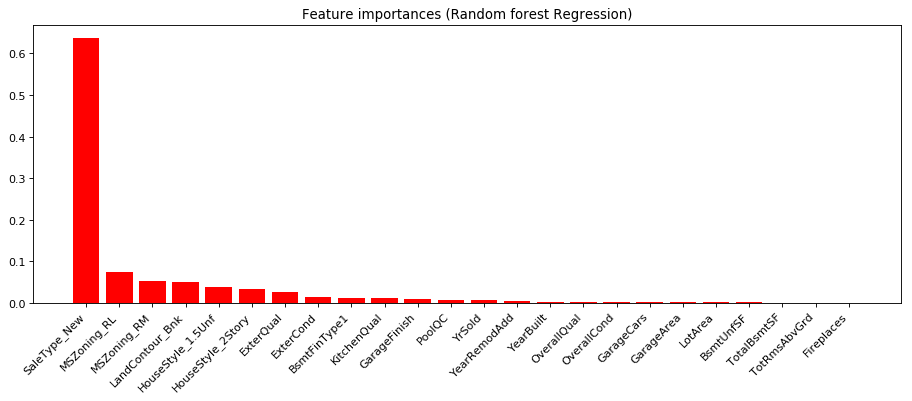

In [1515]:
print("Mean square error for SVM regressor")
print(mean_absolute_error(Y_val, svmY_pred))
print("Determination coefficient(score) for SVM regressor")
print(regr_dt.score(X_val, svmY_pred ))
print("Mean square error for KNN regressor")
print(mean_absolute_error(knnY_pred,Y_val))
print("Determination coefficient(score) for KNN regressor")
print(regr_knn.score(X_val, knnY_pred))
print("Mean square error for linear regressor")
print(mean_absolute_error(lrY_pred,Y_val))
print("Determination coefficient(score) for linear regressor")
print(regr_lr.score(X_val, lrY_pred))
print("Mean square error for random forest regressor")
print(mean_absolute_error(rfY_pred,Y_val))
print("Determination coefficient(score) for random forest regressor")
print(regr_rf.score(X_val, rfY_pred))
print("")
print("Random forest feature importance")
treshold = 0.002
coefs = np.array([])
columns = []
#print(regr_rf.feature_importances_)
for i, f in enumerate(regr_rf.feature_importances_):
    if (f > treshold):
        #print(data_usefull_te.columns[i])
        coefs = np.append(_coefs,[f],axis=0)
        columns.append(data_usefull_te.columns[i])
indices = np.argsort(coefs)[::-1]
plt.figure(figsize=(14, 6), dpi=80)
plt.title("Feature importances (Random forest Regression)")
plt.bar(range(len(columns)), coefs[indices[:len(columns)]],
       color="r", align="center")
plt.xticks(range(len(columns)), columns, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

Stacking

In [1516]:
# Usefull function from webinar practice (a little bit changed)
def get_meta_features(regr, x_train, y_train, x_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(x_test.values[:,0], dtype=float)
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(x_train, y_train)):
        regr.fit(x_train.iloc[train_ind], y_train[train_ind])
        meta_train[test_ind] = regr.predict(x_train.iloc[test_ind])
        meta_test += regr.predict(x_test)
    return meta_train, meta_test / stack_cv.n_splits

In [1517]:
#Creation of model objects of first level of stacking
sregr_rf = RandomForestRegressor(max_depth=7, random_state=31,  n_estimators=30)
sregr_dtr = DecisionTreeRegressor(max_depth=5, random_state=1)
sregr_knn = KNeighborsRegressor(n_neighbors=5)
sregr_lr = LinearRegression()
sregr_svm = SVR(gamma='scale', C=1.0, epsilon=0.2)
print(Y_train.shape)

(730, 1)


In [1518]:
# Creation of Crossvalidation engine object
stack_cv = StratifiedKFold(n_splits=10, random_state=555)

# Definition of global variables
meta_train = []
meta_test = []
col_names = []

# Get metafeature of linear regressor
print('Linear regression features...')
meta_tr, meta_te = get_meta_features(sregr_lr, X_train, Y_train.values[:,0], X_val, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

# Get metafeature of KNN regressor
print('KNN features...')
meta_tr, meta_te = get_meta_features(sregr_knn, X_train, Y_train.values[:,0], X_val, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knn_pred')

# Get metafeature of Support Vectore Machine regressor
print('SVM features...')
meta_tr, meta_te = get_meta_features(sregr_svm, X_train, Y_train.values[:,0], X_val, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svr_pred')

Linear regression features...
KNN features...


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


SVM features...


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [1519]:
# Transformation of sequential set of array to set of columns of dataframe
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [1520]:
# Cretion of model object of second level of stacking
regr_meta = RandomForestRegressor(max_depth=7, random_state=31,  n_estimators=30)
# Learning of model of second level of stacking
regr_meta.fit(X_meta_train, Y_train)

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=31, verbose=0, warm_start=False)

In [1521]:
# Unused function is reserved for collection
def feature_importances_(self):
        """Return the feature importances (the higher, the more important the
           feature).
        Returns
        -------
        feature_importances_ : array, shape = [n_features]
        """
        if self.estimators_ is None or len(self.estimators_) == 0:
            raise NotFittedError("Estimator not fitted, "
                                 "call `fit` before `feature_importances_`.")

        all_importances = Parallel(n_jobs=self.n_jobs,
                                   backend="threading")(
            delayed(getattr)(tree, 'feature_importances_')
            for tree in self.estimators_)

        return sum(all_importances) / len(self.estimators_)
#Get predictions for test dataset
ssvmY_pred = sregr_svm.predict(X_val)
sknnY_pred = sregr_knn.predict(X_val)
slrY_pred = sregr_lr.predict(X_val)
#srfY_pred = sregr_rf.predict(X_val) 
print("Mean square error for SVM regressor")
print(mean_absolute_error(Y_val, ssvmY_pred))
print("Determination coefficient(score) for SVM regressor")
print(sregr_svm.score(X_val, ssvmY_pred ))
print("Mean square error for KNN regressor")
print(mean_absolute_error(sknnY_pred,Y_val))
print("Determination coefficient(score) for KNN regressor")
print(sregr_knn.score(X_val, sknnY_pred))
print("Mean square error for linear regressor")
print(mean_absolute_error(slrY_pred,Y_val))
print("Determination coefficient(score) for linear regressor")
print(regr_lr.score(X_val, slrY_pred))
#print("Mean square error for random forest regressor")
#print(mean_absolute_error(srfY_pred,Y_val))
#print("Determination coefficient(score) for random forest regressor")
#print(sregr_rf.score(X_val, srfY_pred))
print("")
y_pred_meta_test = regr_meta.predict(X_meta_test)
print("Determination coefficient(score) for stacking")
print(regr_meta.score(X_meta_test, y_pred_meta_test))
print("Mean square error for stacking")
print(mean_absolute_error(y_pred_meta_test,Y_val))
print("")
print("Meta feature importance")
#coefs = np.abs(regr_meta.coef_[0])
coefs = np.abs(regr_meta.feature_importances_)
print(coefs)

Mean square error for SVM regressor
57188.9378633246
Determination coefficient(score) for SVM regressor
1.0
Mean square error for KNN regressor
30661.525479452055
Determination coefficient(score) for KNN regressor
1.0
Mean square error for linear regressor
65942623696703.32
Determination coefficient(score) for linear regressor
-0.5448551011297111

Determination coefficient(score) for stacking
1.0
Mean square error for stacking
25582.05678333186

Meta feature importance
[0.89061492 0.04676233 0.06262274]


В случае если в качестве регрессора первго уровня выбран случайный лес, а для регрессора второго уровня чтото другое, то Стекинг не только не улучшает результат по сравнению с применением случайного леса без стекинга, но и немного ухудшает. Но если среди регрессоров первого уровня нет случайного леса, то улучшение есть. Линейная регрессия показала себя очень плохо.